# Loads data from relevant api 

In [17]:
import requests
from config import API_KEY

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
url = "https://twelve-data1.p.rapidapi.com/time_series"

querystring = {"symbol":"EUR/USD",
               "interval":"15min",
               "outputsize":"5000",
               "format":"json"}

headers = {
	"X-RapidAPI-Key": API_KEY,
	"X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

In [19]:
df_in = pd.json_normalize(response.json()['values'], 
                        meta=['datetime', 'open', 'high', 'low', 'close', ])
df_in[['open', 'high', 'low', 'close', ]] = df_in[['open', 'high', 'low', 'close',]].apply(pd.to_numeric)
df = df_in.copy().iloc[::-1].reset_index(drop=True)
df.drop(index=0)
df

,datetime,open,high,low,close
0,2023-09-20 16:00:00,1.06800,1.06880,1.06730,1.06870
1,2023-09-20 16:15:00,1.06860,1.06920,1.06860,1.06900
2,2023-09-20 16:30:00,1.06900,1.06930,1.06870,1.06930
3,2023-09-20 16:45:00,1.06920,1.06940,1.06810,1.06820
4,2023-09-20 17:00:00,1.06820,1.06840,1.06760,1.06770
...,...,...,...,...,...
4995,2023-12-01 23:45:00,1.08885,1.08890,1.08750,1.08770
4996,2023-12-02 00:00:00,1.08770,1.08825,1.08730,1.08780
4997,2023-12-02 00:15:00,1.08780,1.08850,1.08760,1.08810
4998,2023-12-02 00:30:00,1.08800,1.08825,1.08690,1.08695


Text(0, 0.5, 'Avg EUR/USD')

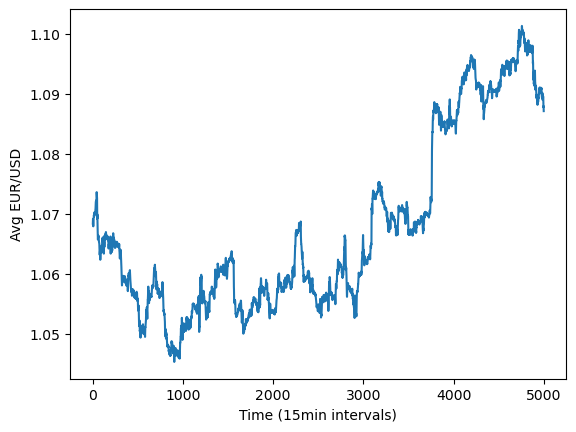

In [20]:
df['avg'] = df[['open','close']].mean(axis=1)
plt.plot(df['avg'])
plt.xlabel('Time (15min intervals)')
plt.ylabel('Avg EUR/USD')

In [21]:
df['returns'] = np.log(df['avg'] / df['avg'].shift(1)) 
df.dropna(inplace=True)
df['direction'] = np.sign(df['returns']).astype(int)

(array([3.000e+00, 5.000e+00, 1.700e+01, 2.110e+02, 3.345e+03, 1.329e+03,
        7.600e+01, 8.000e+00, 2.000e+00, 3.000e+00]),
 array([-0.00299465, -0.00236932, -0.00174398, -0.00111865, -0.00049331,
         0.00013202,  0.00075736,  0.00138269,  0.00200803,  0.00263336,
         0.0032587 ]),
 <BarContainer object of 10 artists>)

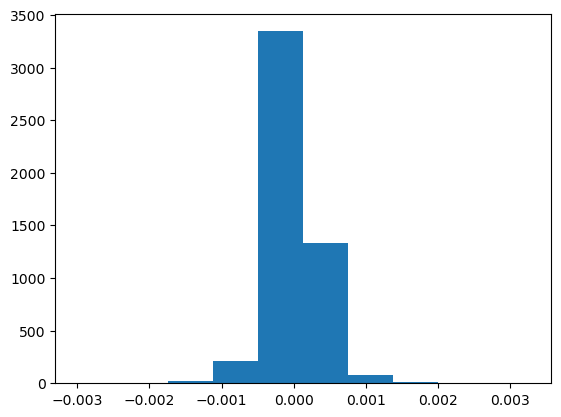

In [22]:
plt.hist(df['returns'])

In [23]:
def add_lagged_columns(df, column_to_lag, num_lags):
    """
    Add lagged columns to a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_to_lag (str): The column for which lagged columns are created.
        num_lags (int): The number of lagged columns to add.
    
    Returns:
        output_df: containing the direction and the lagged returns cols
    """
    cols = []
    for i in range(1, num_lags + 1):
        cols.append(f'{column_to_lag}_lag{i}')
        df[f'{column_to_lag}_lag{i}'] = df[column_to_lag].shift(i)
    return  cols

In [24]:
num_lags = 5
x_cols = add_lagged_columns(df,'returns', num_lags)
df.dropna(inplace=True)
df

,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5
6,2023-09-20 17:30:00,1.06800,1.06910,1.06800,1.06890,1.068450,0.000515,1,-0.000047,-0.000702,-0.000421,0.000327,0.000421
7,2023-09-20 17:45:00,1.06895,1.06930,1.06880,1.06905,1.069000,0.000515,1,0.000515,-0.000047,-0.000702,-0.000421,0.000327
8,2023-09-20 18:00:00,1.06900,1.06930,1.06890,1.06910,1.069050,0.000047,1,0.000515,0.000515,-0.000047,-0.000702,-0.000421
9,2023-09-20 18:15:00,1.06900,1.06960,1.06890,1.06945,1.069225,0.000164,1,0.000047,0.000515,0.000515,-0.000047,-0.000702
10,2023-09-20 18:30:00,1.06940,1.06970,1.06920,1.06945,1.069425,0.000187,1,0.000164,0.000047,0.000515,0.000515,-0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-12-01 23:45:00,1.08885,1.08890,1.08750,1.08770,1.088275,-0.000964,-1,-0.000161,-0.000069,0.000252,0.000184,-0.000046
4996,2023-12-02 00:00:00,1.08770,1.08825,1.08730,1.08780,1.087750,-0.000483,-1,-0.000964,-0.000161,-0.000069,0.000252,0.000184
4997,2023-12-02 00:15:00,1.08780,1.08850,1.08760,1.08810,1.087950,0.000184,1,-0.000483,-0.000964,-0.000161,-0.000069,0.000252
4998,2023-12-02 00:30:00,1.08800,1.08825,1.08690,1.08695,1.087475,-0.000437,-1,0.000184,-0.000483,-0.000964,-0.000161,-0.000069


In [27]:
df_train = df.copy().iloc[0:4000,:]
df_test = df.copy().iloc[4000:,:]

df_train.to_csv(f'./{querystring['symbol'].replace('/', '')}_train.csv')
df_test.to_csv(f'./{querystring['symbol'].replace('/', '')}_test.csv')

In [28]:
pd.read_csv('./EURUSD_train.csv')

,Unnamed: 0,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5
0,6,2023-09-20 17:30:00,1.06800,1.0691,1.06800,1.06890,1.068450,0.000515,1,-0.000047,-0.000702,-0.000421,0.000327,0.000421
1,7,2023-09-20 17:45:00,1.06895,1.0693,1.06880,1.06905,1.069000,0.000515,1,0.000515,-0.000047,-0.000702,-0.000421,0.000327
2,8,2023-09-20 18:00:00,1.06900,1.0693,1.06890,1.06910,1.069050,0.000047,1,0.000515,0.000515,-0.000047,-0.000702,-0.000421
3,9,2023-09-20 18:15:00,1.06900,1.0696,1.06890,1.06945,1.069225,0.000164,1,0.000047,0.000515,0.000515,-0.000047,-0.000702
4,10,2023-09-20 18:30:00,1.06940,1.0697,1.06920,1.06945,1.069425,0.000187,1,0.000164,0.000047,0.000515,0.000515,-0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4001,2023-11-17 13:15:00,1.08540,1.0855,1.08520,1.08540,1.085400,0.000023,1,0.000023,0.000046,0.000000,-0.000046,0.000138
3996,4002,2023-11-17 13:30:00,1.08520,1.0854,1.08485,1.08500,1.085100,-0.000276,-1,0.000023,0.000023,0.000046,0.000000,-0.000046
3997,4003,2023-11-17 13:45:00,1.08500,1.0857,1.08500,1.08550,1.085250,0.000138,1,-0.000276,0.000023,0.000023,0.000046,0.000000
3998,4004,2023-11-17 14:00:00,1.08555,1.0857,1.08540,1.08560,1.085575,0.000299,1,0.000138,-0.000276,0.000023,0.000023,0.000046


In [29]:
pd.read_csv('EURUSD_test.csv')

,Unnamed: 0,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5
0,4006,2023-11-17 14:30:00,1.08555,1.08570,1.08530,1.08545,1.085500,-0.000092,-1,0.000023,0.000299,0.000138,-0.000276,0.000023
1,4007,2023-11-17 14:45:00,1.08545,1.08560,1.08530,1.08540,1.085425,-0.000069,-1,-0.000092,0.000023,0.000299,0.000138,-0.000276
2,4008,2023-11-17 15:00:00,1.08540,1.08560,1.08520,1.08525,1.085325,-0.000092,-1,-0.000069,-0.000092,0.000023,0.000299,0.000138
3,4009,2023-11-17 15:15:00,1.08525,1.08540,1.08520,1.08530,1.085275,-0.000046,-1,-0.000092,-0.000069,-0.000092,0.000023,0.000299
4,4010,2023-11-17 15:30:00,1.08530,1.08550,1.08530,1.08550,1.085400,0.000115,1,-0.000046,-0.000092,-0.000069,-0.000092,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,4995,2023-12-01 23:45:00,1.08885,1.08890,1.08750,1.08770,1.088275,-0.000964,-1,-0.000161,-0.000069,0.000252,0.000184,-0.000046
990,4996,2023-12-02 00:00:00,1.08770,1.08825,1.08730,1.08780,1.087750,-0.000483,-1,-0.000964,-0.000161,-0.000069,0.000252,0.000184
991,4997,2023-12-02 00:15:00,1.08780,1.08850,1.08760,1.08810,1.087950,0.000184,1,-0.000483,-0.000964,-0.000161,-0.000069,0.000252
992,4998,2023-12-02 00:30:00,1.08800,1.08825,1.08690,1.08695,1.087475,-0.000437,-1,0.000184,-0.000483,-0.000964,-0.000161,-0.000069
